# GAN : Genrative Adversarial Network(적대적 생성망)

### https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

## Generator(G) 모델과 이를 분간하는 Discriminator(D) 모델 간의 경쟁을 통해 이미지 생성

## G 는 D가 이를 제대로 판별 못하도록 학습, D는 이를 잘 구분하도록 학습

## 이를  Minmax two player game 프레임워크로 제안

## 역전파와 드롭아웃 알고리즘을 이용, 마르코프 체인은 사용하지 않는다

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [73]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = FashionMNIST(root = './data', download = True, train = True, transform = transform)
trainloader = DataLoader(trainset, batch_size = 100, shuffle = True)

In [74]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784        # 28 x 28
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),   #음수 구간 그래프가 y = 0.2 x
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2), 
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh())
        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [75]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        
        return x

In [76]:
generator = Generator()
discriminator = Discriminator()

In [77]:
g_optim = optim.Adam(generator.parameters(), lr = 2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr = 2e-4)

g_losses = []
d_losses= []
images = []
criterion = nn.BCELoss()

In [78]:
def noise(n, n_features = 128):
    data = torch.randn(n, n_features)
    return data

def label_ones(size):
    data = torch.ones(size, 1)
    return data

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data

In [79]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))
    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [80]:
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

In [81]:
test_noise = noise(64)
l = len(trainloader)


for epoch in range(71):
    g_loss = 0
    d_loss = 0
    for data in trainloader:
        imgs, _  = data
        n = len(imgs)
        fake_data = generator(noise(n)).detach()
        real_data = imgs
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data =generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)
    
    img = generator(test_noise).detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss / l)
    d_losses.append(d_loss / l)
    if epoch % 10 == 0:
        print(f'epoch : {epoch:.3f}, g_loss : {g_loss:.3f}, d_loss : {d_loss:.3f}')

epoch : 0.000, g_loss : 1348.627, d_loss : 526.325
epoch : 10.000, g_loss : 998.854, d_loss : 524.770
epoch : 20.000, g_loss : 884.316, d_loss : 588.437
epoch : 30.000, g_loss : 778.995, d_loss : 620.597
epoch : 40.000, g_loss : 727.034, d_loss : 639.656
epoch : 50.000, g_loss : 705.250, d_loss : 651.801
epoch : 60.000, g_loss : 703.339, d_loss : 654.526
epoch : 70.000, g_loss : 668.517, d_loss : 675.048


In [82]:
torch.save(discriminator.state_dict(), './fmnist_disc1.pth')
torch.save(generator.state_dict(), './fmnist_gner1.pth')

In [83]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items1.gif', imgs)

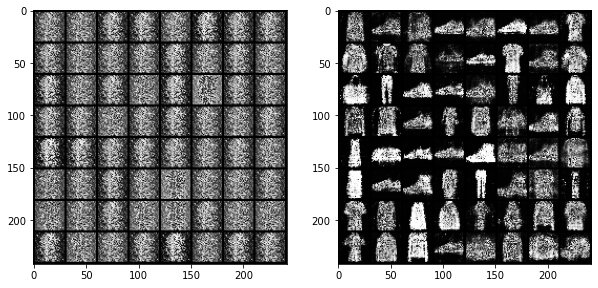

In [84]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(imgs[0])
plt.subplot(122)
plt.imshow(imgs[69])

Text(0.5, 1.0, 'Loss')

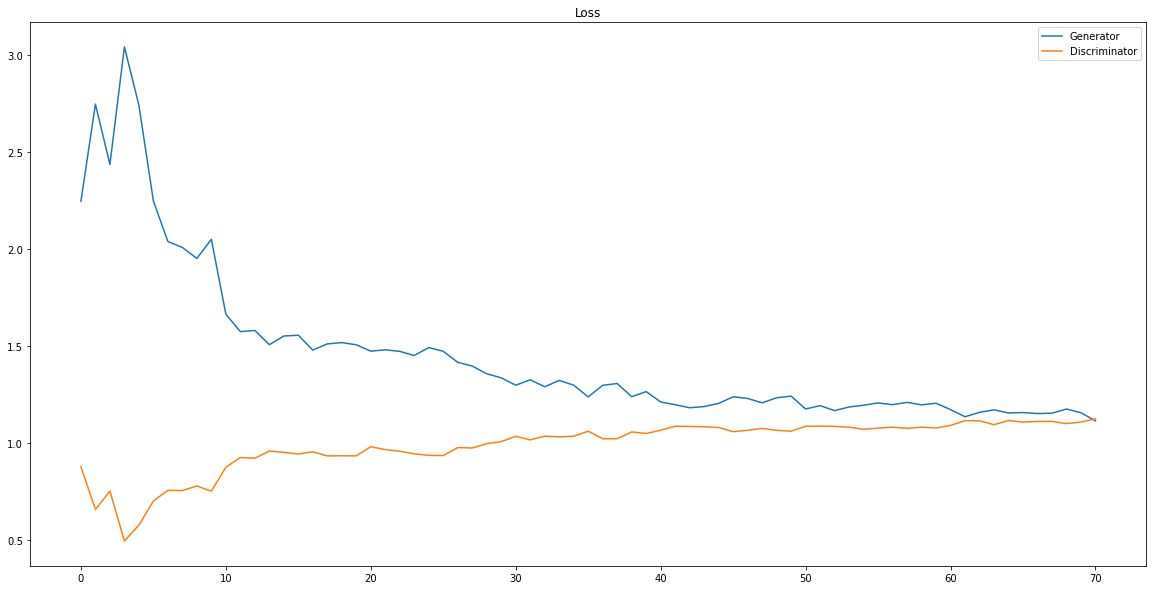

In [85]:
plt.figure(figsize = (20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')